In [1]:
import os
import os.path

import numpy as np
import torch as T
import copy
import time
import matplotlib.pyplot as plt

import PyccatPO
from PyccatPO import First_computing,model_ccat,read_input

import Kirchhoffpy
from Kirchhoffpy.Spheical_field import spheical_grid
from Kirchhoffpy.coordinate_operations import Coord

from Kirchhoffpy.coordinate_operations import Transform_local2global as local2global
from Kirchhoffpy.coordinate_operations import Transform_global2local as global2local
from Kirchhoffpy.coordinate_operations import cartesian_to_spherical as cart2spher
from Kirchhoffpy.Feedpy import CO,dotproduct
c=299792458


def field_calculation(source_field,frequency=100,
                      defocus=[0,0,705],
                      M2_N=[15,15],M1_N=[15,15],
                      fimag_N =[301,301],fimag_size =[700,700]):
    inputfile='CCAT_model'
    ad_m2=np.zeros(5*69)
    ad_m1=np.zeros((5,77))
    Lambda = c/(frequency*10**9)*1000
    k=2*np.pi/Lambda
    #sourcefile='beam'
    # 0. read the input parameters from the input files;
    coefficient_m2,coefficient_m1,List_m2,List_m1,M2_size,M1_size,R2,R1,p_m2,q_m2,p_m1,q_m1,M2_x,M1_x,fimag_X,fimag_sizeX,distance,edge_taper,Angle_taper,k_x=read_input(inputfile);
    
    # 1. produce the coordinate system;
    # 2. build model;
    print(M2_N,M1_N)
    print(fimag_N)
    m2,m2_n,m2_dA,m1,m1_n,m1_dA,fimag,fimag_n,fimag_dA=model_ccat(coefficient_m2,List_m2,M2_size[0],M2_size[1],M2_N[0],M2_N[1],R2,
                                                                  coefficient_m1,List_m1,M1_size[0],M1_size[1],M1_N[0],M1_N[1],R1,
                                                                  fimag_size[0],fimag_size[1],fimag_N[0],fimag_N[1],
                                                                  ad_m2,ad_m1,p_m2,q_m2,p_m1,q_m1);
    
    # 3.calculate the source beam
    Field_fimag_E,Field_fimag_H,Field_m1_E,Field_m1_H,Field_s_E,Field_s_H=First_computing(m2,m2_n,m2_dA,
                                                                                          m1,m1_n,m1_dA,
                                                                                          fimag,fimag_n,
                                                                                          fimag_dA,defocus,
                                                                                          source_field,k,
                                                                                          Angle_taper,edge_taper,Keepmatrix=False);
    
    return Field_fimag_E,Field_fimag_H,Field_m1_E,Field_m1_H,Field_s_E,Field_s_H


# near field calculation
def near_field(outputfolder,freq,Ns=201,
               defocus = [0,0,705],
               M2_N=[15,15],M1_N=[15,15],
               fimag_N =[301,301],fimag_size =[700,700]):
    Folder = outputfolder +str(freq)+'GHz/'
    if os.path.isdir(Folder):
        print("Exists")
    else:
        print("Doesn't exists")
        os.mkdir(Folder)
    angle_s=[0,np.pi,0]      
    D_s=[0,0,0]

    if freq ==296:
        u = 0.01
        v = 0.01
    elif freq == 100:
        u = 0.03
        v = 0.03 
    source_field=spheical_grid(-u/2,u/2,-v/2,v/2,Ns,Ns,distance=300*10**3)
    source0=np.concatenate((source_field.x,source_field.y,source_field.z)).reshape(3,-1).T
    source=Coord()
    #source0=np.genfromtxt(sourcefile+'/on-axis.txt',delimiter=',');
    source.x=source0[...,0];source.y=source0[...,1];source.z=source0[...,2]
    
    Field_fimag_E,Field_fimag_H,Field_m1_E,Field_m1_H,Field_s_E,Field_s_H = field_calculation(source,
                                                                                              frequency=freq,
                                                                                              defocus=defocus,
                                                                                              M2_N=M2_N,
                                                                                              M1_N=M1_N,
                                                                                              fimag_N =fimag_N,
                                                                                              fimag_size =fimag_size)
    
    # calculate the co cx crho vectorsl;
    r,theta,phi=cart2spher(source.x,source.y,source.z)
    co,cx,crho=CO(theta,phi)

    Field_s_E.N=[]
    Field_s_E1=global2local(angle_s,[0,0,0],Field_s_E)

    F_co=dotproduct(Field_s_E1,co)
    F_cx=dotproduct(Field_s_E1,cx)
    F_crho=dotproduct(Field_s_E1,crho)

    #Sx=(Field_s_E.x.real+1j*Field_s_E.x.imag).reshape(Ns,Ns);
    #Sy=(Field_s_E.y.real+1j*Field_s_E.y.imag).reshape(Ns,Ns);
    #Sz=(Field_s_E.z.real+1j*Field_s_E.z.imag).reshape(Ns,Ns);

    Sx=(F_co.real+1j*F_co.imag).reshape(Ns,Ns)
    Sy=(F_cx.real+1j*F_cx.imag).reshape(Ns,Ns)
    Sz=(F_crho.real+1j*F_crho.imag).reshape(Ns,Ns)

    fig=plt.figure(figsize=(8,7))
    plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sx)))
    plt.xlabel('near-feild beam in amplitude (dB)',fontsize=18,color='darkred')
    plt.colorbar()
    plt.savefig(Folder+'near_field_beam.png')

    fig=plt.figure(figsize=(8,7))
    plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sy)))
    plt.xlabel('near-feild beam in amplitude (dB)',fontsize=18,color='darkred')
    plt.colorbar()
    plt.savefig(Folder+'near_field_beam_y.png')

    fig=plt.figure(figsize=(8,7))
    plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sz)))
    plt.xlabel('near-feild beam in amplitude (dB)',fontsize=18,color='darkred')
    plt.colorbar()
    plt.savefig(Folder+'near_field_beam_z.png')

    Source=np.concatenate((Sx.real,Sx.imag,Sy.real,Sy.imag,Sz.real,Sz.imag)).reshape(6,-1).T
    np.savetxt(Folder+'source_field.txt',Source,delimiter=',')

    Field_IF=np.concatenate((Field_fimag_E.x.real,Field_fimag_E.x.imag,
                             Field_fimag_E.y.real,Field_fimag_E.y.imag,
                             Field_fimag_E.z.real,Field_fimag_E.z.imag)).reshape(6,-1).T
    np.savetxt(Folder+'IF_field.txt',Field_IF,delimiter=',')

    Field_M1=np.concatenate((Field_m1_E.x.real,Field_m1_E.x.imag,Field_m1_E.y.real,Field_m1_E.y.imag,Field_m1_E.z.real,Field_m1_E.z.imag)).reshape(6,-1).T
    np.savetxt(Folder+'M1_field.txt',Field_M1,delimiter=',')

    




In [2]:
folder = 'output/infocus/'
if os.path.isdir(folder):
    print("Exists")
else:
    print("Doesn't exists")
    os.mkdir(folder) 

Exists


Exists
[15, 15] [15, 15]
[301, 301]
2
3
4
time used: 566.1160394


C:\Users\xiaod\AppData\Local\Temp\ipykernel_7640\3980832023.py:111: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sx)))
C:\Users\xiaod\AppData\Local\Temp\ipykernel_7640\3980832023.py:117: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sy)))
C:\Users\xiaod\AppData\Local\Temp\ipykernel_7640\3980832023.py:123

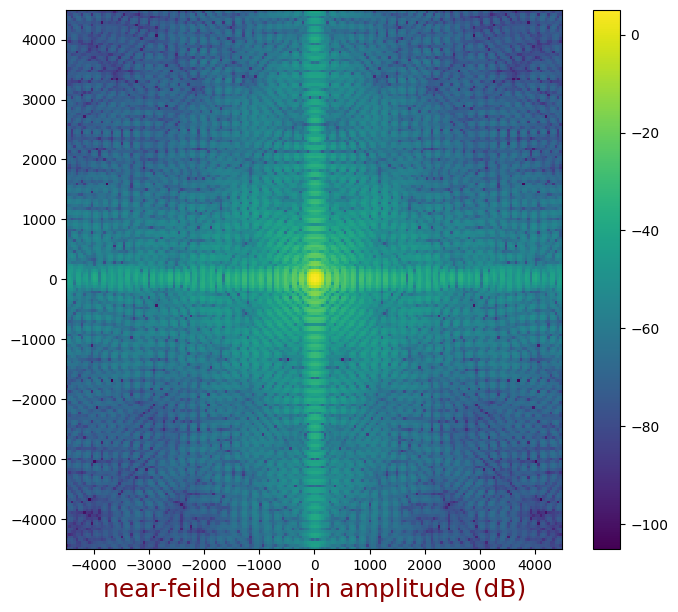

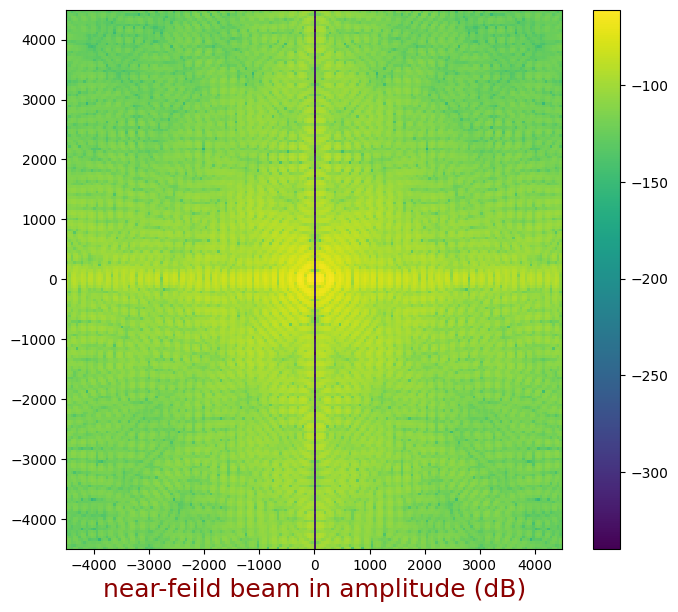

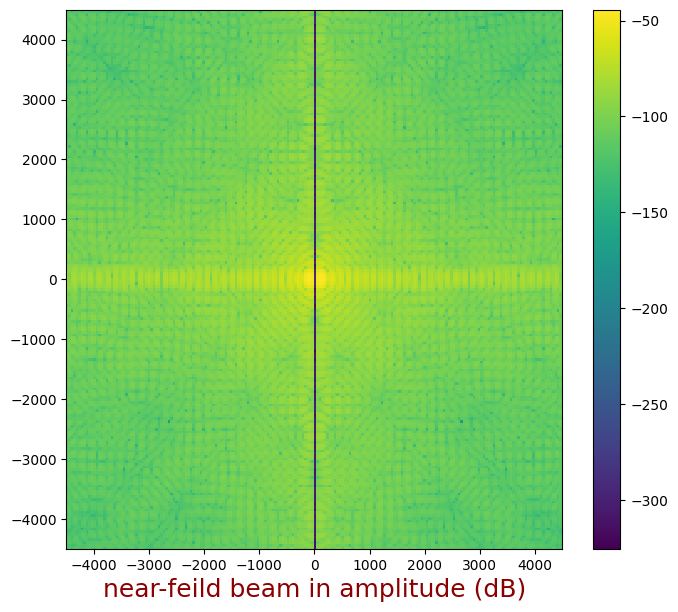

In [3]:
Frequency = 100

near_field(folder,Frequency,Ns=201,
            defocus = [0,0,705],
            M2_N=[15,15],M1_N=[15,15],
            fimag_N =[301,301],fimag_size =[1000*3,1000*3])

In [ ]:
B = T.zeros((3,4,5))
A = T.tensor(np.linspace(1,56,6).reshape(-1,1))
B[0,:,:] = A





A=T.ones((3,5))
B= T.zeros((3,6,5))
B[:,0,:] = T.tensor(np.linspace(1,6,6).reshape(-1,1))
B[:,1,:] = T.tensor(np.linspace(1,6,6).reshape(-1,1))*2
B[:,2,:] = T.tensor(np.linspace(1,6,6).reshape(-1,1))*3

In [67]:
B = T.zeros((3,4,5))
A = T.tensor(np.linspace(1,5,5))
B[0,:,:] =  A
B[1,:,:] = A*2
B[2,:,:] =  A*3

In [80]:
B

tensor([[[ 1.,  2.,  3.,  4.,  5.],
         [ 1.,  2.,  3.,  4.,  5.],
         [ 1.,  2.,  3.,  4.,  5.],
         [ 1.,  2.,  3.,  4.,  5.]],

        [[ 2.,  4.,  6.,  8., 10.],
         [ 2.,  4.,  6.,  8., 10.],
         [ 2.,  4.,  6.,  8., 10.],
         [ 2.,  4.,  6.,  8., 10.]],

        [[ 3.,  6.,  9., 12., 15.],
         [ 3.,  6.,  9., 12., 15.],
         [ 3.,  6.,  9., 12., 15.],
         [ 3.,  6.,  9., 12., 15.]]])

In [79]:
T.sum(B,axis=-1)

tensor([[15., 15., 15., 15.],
        [30., 30., 30., 30.],
        [45., 45., 45., 45.]])

In [73]:
b=T.sqrt(T.sum(B**2,axis=0))
B/b

tensor([[[0.2673, 0.2673, 0.2673, 0.2673, 0.2673],
         [0.2673, 0.2673, 0.2673, 0.2673, 0.2673],
         [0.2673, 0.2673, 0.2673, 0.2673, 0.2673],
         [0.2673, 0.2673, 0.2673, 0.2673, 0.2673]],

        [[0.5345, 0.5345, 0.5345, 0.5345, 0.5345],
         [0.5345, 0.5345, 0.5345, 0.5345, 0.5345],
         [0.5345, 0.5345, 0.5345, 0.5345, 0.5345],
         [0.5345, 0.5345, 0.5345, 0.5345, 0.5345]],

        [[0.8018, 0.8018, 0.8018, 0.8018, 0.8018],
         [0.8018, 0.8018, 0.8018, 0.8018, 0.8018],
         [0.8018, 0.8018, 0.8018, 0.8018, 0.8018],
         [0.8018, 0.8018, 0.8018, 0.8018, 0.8018]]])

In [74]:
b.shape

torch.Size([4, 5])

In [39]:
m=T.sum(B**2,axis=1)
m

tensor([[ 14.,  14.,  14.,  14.,  14.],
        [ 56.,  56.,  56.,  56.,  56.],
        [126., 126., 126., 126., 126.],
        [224., 224., 224., 224., 224.],
        [350., 350., 350., 350., 350.],
        [504., 504., 504., 504., 504.]])

In [ ]:
factor